# Introduction to ANN with Keras

## Setup Environment

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# to make this notebook's output stable across runs
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## Classification model using Sequential API

We will be using the Fashion MNIST dataset. It is the exact same format as the digit-image MNIST dataset (70,000 greyscale images of 28 x 28 pixels each, with 10 classes), however, images of various fashion items are used instead of hand written digits.

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

Notible differences when loading these datasets using Keras rather than Scikit-Learn are
1. Every image is represented as a 28x28 array rather than a 1D array of size 784
2. Pixel intensities are represented as integers (0-255) rather than floats (0.0-255.0)

In [4]:
print("Training data has shape {} with data of type {}".format(X_train_full.shape, X_train_full.dtype))

Training data has shape (60000, 28, 28) with data of type uint8


- The training set contains 60,000 grayscale images, each 28x28 pixels
- Each pixel intensity is represented as a byte (0 to 255):

In [5]:
# Missing a validation set, this need to be created
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# Scale input features
X_valid, X_train = X_valid / 255.0, X_train / 255.0
X_test = X_test / 255.0

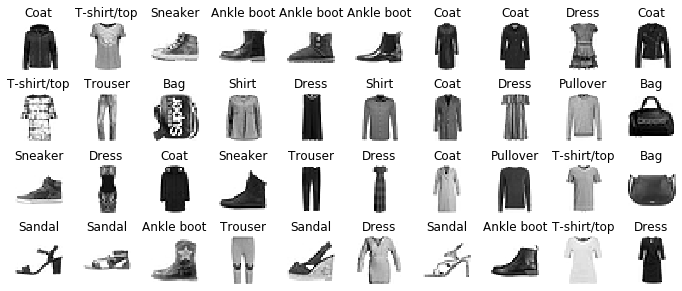

In [6]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
        
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [7]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

- `keras.models.Sequential` is the simplest kind of Keras model for neural networks. It is composed of a single stack of layers connected sequentially. AKA the sequential API.
- `keras.layers.Flatten` builds the first layer by converting each input image in a 1D array. Ie, stacking the rows (or columns) of pixels into a single long array. The `input_shape` must also be specified and is the pixel dimensions of each image.
- Each `keras.layers.Dense` is a single layer with the specified # of neurons and activation fucntion.
- The final dense layer uses the `softmax` activation function becuase this mdoel is for classification of classes where each class is exclusive.

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="sgd",
    metrics=["accuracy"]) # can add other metrics to computer during training and evaluation

In [10]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), verbose=False)

(0, 1)

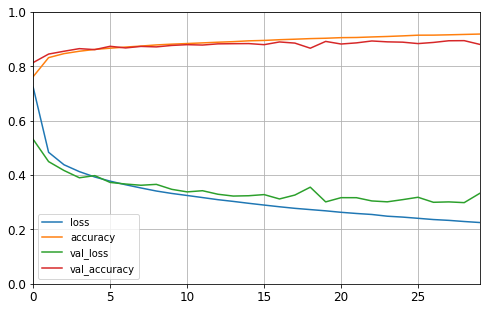

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

- Model looks like it performed better on the validation set than on the training set at the beginning of the training. But that's not the case: the validation error is computed at the end of each epoch, while the training error is computed using a running mean during each epoch. The training curve whould be thenfore be shifted be half an epoch to the left.

In [12]:
pd.DataFrame(data=model.evaluate(X_test, y_test, verbose=False), index=model.metrics_names).T

,loss,accuracy
0,0.367229,0.867


In [13]:
# Make some predicitons
X_new = X_test[:3]
y_pred = model.predict_classes(X_new)
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

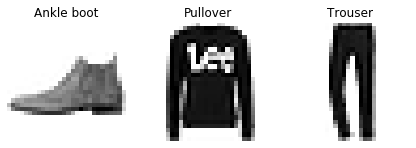

In [14]:
plt.figure(figsize=(7.2, 2.4))

# plot predictions against actual
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Regression model using Sequential API

In [15]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [16]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 30)                270       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), verbose=False)

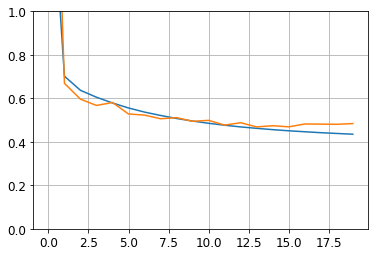

In [18]:
mse_test = model.evaluate(X_test, y_test, verbose=False)
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [19]:
X_new = X_test[:3]
model.predict(X_new)

array([[0.77513033],
       [1.6858633 ],
       [3.352915  ]], dtype=float32)

## Building Complex Models Using the Functional API

- One example of a nonsequential NN is a _wide & deep_ neural network
- It connects all of part fo the inputs directly to the output layer.
- Allows the NN to learn both deep patters and simple rules

In [20]:
# Get some data

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print("Training data has shape {} with data of type {}".format(X_train_full.shape, X_train_full.dtype))

Training data has shape (15480, 8) with data of type float64


In [21]:
# Building a deep and wide NN

# Specifies the shape and dtype of the input layer
input_ = keras.layers.Input(shape=X_train.shape[1:])

# Add a couple of dense layers with the relu activate fn
hidden1 = keras.layers.Dense(30, activation="relu")(input_)  # Notice input_ layer auto passed
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1) # Notice previous hidden1 layer auto passed

# Takes input from two previous inputs, 
concat = keras.layers.concatenate([input_, hidden2])

# Output layer from previous concat layer
output = keras.layers.Dense(1)(concat)

# Smush it all together and choose a loss fn and optimiser
model = keras.models.Model(inputs=[input_], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [22]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), verbose=False)

(0, 1)

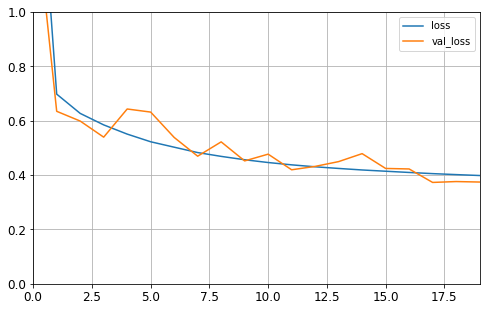

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

- But, what if we wanted to send a subset of the features through the wide path and a different subset (possibly overlapping) through the deep path.
- Solution: Use multiple inputs

In [24]:
# Specified two inputs
input_A = keras.layers.Input(shape=[5], name="wide_input") # Send 5 features down the wide
input_B = keras.layers.Input(shape=[6], name="deep_input") # Send 6 down the deep

# Notice that the two inputs are fed into differnt layers of the NN
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)

# Finish up the model, selecting inputs and outputs
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [25]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

# 0-4 first features in input_A, 2-7 features in input_B
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit(epochs=20, verbose=False,
    # Need to pass two inputs for x
    x=(X_train_A, X_train_B), y=y_train,
    # Likewise for validataion data
    validation_data=((X_valid_A, X_valid_B), y_valid))

Why do this?

- May need to make multiple predictions. Example, may want to locate and classify the main object in a picture. This is both a regression task (coords of object, plus height and width) and a classification task.
- May have multiple independent tasks based on the same data. Results may be better by training on a single NN rather than 2 (or more). For example, could perform multitask classification on pictures of faces, using one output to classify expression and another to identity glasses (or not).
- Can be used as a form of regularisation. Can add extra output to ensure NN is learning correctly.

## Using the Subclassing API to Build Dynamic Models

Benifits of Sequential & Functional API (declarative)

- Model can be easily saved, cloned and shared
- Its structure can be displayed and analyzed
- The framework can infer shapes and check types (easier debugging)

Main drawback is that its static, making it inflexible enough to prevent incorperating loops, varying shapes, conditional branching and other dynamic behavious.

In contrast, the imperative style of the Subclassing API can allieviate these problems.

In [26]:
# First need to subclass keras Model class
class WideAndDeepModel(keras.models.Model):
    
    # Create the layers you want in the constructor
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs) # handles standard args (e.g., name)
        
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
    
    # Use defined layers in computations here
    def call(self, inputs):
        input_A, input_B = inputs # mirrors the two input example from above
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output


model = WideAndDeepModel(30, activation="relu")

# Can then go on to compile, eval and use it to make predictions just like earlier examples

Benifits of Subclass API

- Do not need to crease the input, just use the `input` argument to the `call()` method
- Separate the contruction of layers from their usage
- Can include all kinds of dynamic logic in the new `call()` method

Drawbacks include

- Model architechture is now hidden within the `call()` method
- Difficult to save, clone and inspect
- Less detail in `summary()`
- Cannot perform type checking and shapes ahead of time, making mistakes easier and debugging harder

## Saving and Restoring a Model

In [27]:
# Simple example model
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=False)

In [28]:
# Specifies path for log dir
# path = os.path.join(os.curdir, "models")
# os.mkdir(path);

# Keras uses HDF5 format
model.save("models/my_keras_model.h5")
model = keras.models.load_model("./models/my_keras_model.h5")

X_new = X_test[:3]
model.predict(X_new)

array([[0.82658476],
       [1.6162086 ],
       [3.1176856 ]], dtype=float32)

- Saves all model parameters for every layer (connection wieghts and biases)
- Saves optimiser (inc hyperparams and state)
- This method only works with the Sequential and Functional API.
- Using the SubClassing API you can only save/load the weights, everything else is on you!

In [29]:
#model.save_weights("my_keras_weights.ckpt")
#model.load_weights("my_keras_weights.ckpt")

## Using Callbacks

- Lets you specify a list of objects to call at the start and end of training, end of epoch, before/after each batch
- Can even save checkpoints of the model at regular intervals during training
- If using a validation set during training, then there is an option to save only the best model so far. This can help with overfitting, simply restore the last saved model.
- There are many more kinds of call backs available in keras

In [30]:
# Reset model from earlier
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

# Only save best model at each checkpoint (default is after each epoch)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./models/my_keras_model.h5", save_best_only=True)

# Do the fitting
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb], verbose=False)

# Rollback to best model
model = keras.models.load_model("./models/my_keras_model.h5")

In [31]:
model.evaluate(X_test, y_test, verbose=False)

0.3931819044342337

In [32]:
# Again, reset the NN
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

# Stop early after progress on validataion set stops (after n epochs)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=False,
                   callbacks=[checkpoint_cb, early_stopping_cb])

By using both callbacks we,

- Protect against the computer crashing by saving checkpoints
- Interurpt training early if there is no progress
- Using early stopping, no rollback to neseccary since it will automatically restore the best model when finishing

In [33]:
# Can also create custom callbacks
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    
    # Can implement other methods as required
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))
        
    # def on_epoch_begin()...
    
    # def on_train_end()...

val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid), callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
11200/11610 [===========================>..] - ETA: 0s - loss: 0.3810
val/train: 1.14
11610/11610 [==============================] - 1s 102us/sample - loss: 0.3830 - val_loss: 0.4349


## Using TensorBoard for Visualisation

- Visualisation tool that is automatically download with tensorlfow

In [34]:
import os

# Specifies path for log dir
root_logdir = os.path.join(os.curdir, "logs")

In [35]:
# Speficy run by data so that each can be separated
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\logs\\run_2020_03_06-20_34_34'

In [36]:
keras.backend.clear_session()

# again, reset the model
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

# add the logging callback
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, tensorboard_cb], verbose=False)

In [37]:
# load the TensorBoard's Jupyter extension
%load_ext tensorboard
%tensorboard --logdir=./logs --port=6006

# Or run in terminal
# $ tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 3864), started 0:59:09 ago. (Use '!kill 3864' to kill it.)

## Fine-Tuning Neural Network Hyperparameters